## 1002175144
## VINAYBHASKAR_PRATHI

# Part 1

In [1]:
%matplotlib inline

In [2]:
!pip install gym

In [3]:
!pip install gymnasium


# Frozenlake benchmark


In this post we'll compare a bunch of different map sizes on the
[FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)_
environment from the reinforcement learning
[Gymnasium](https://gymnasium.farama.org/)_ using the Q-learning
algorithm.




## Dependencies




Let's first import a few dependencies we'll need.




In [4]:
# Author: Andrea Pierré
# License: MIT License


from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

# %load_ext lab_black

## Parameters we'll use




In [29]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("output_figures"),
)
params
rng = np.random.default_rng(params.seed)

params_2 = Params(
    total_episodes=3000,
    learning_rate=0.5,
    gamma=0.99,
    epsilon=0.2,
    map_size=8,
    seed=42,
    is_slippery=True,
    n_runs=30,
    action_size=None,
    state_size=None,
    proba_frozen=0.8,
    savefig_folder=Path("output_figures2")
)
params_2
rng = np.random.default_rng(params_2.seed)
params_3 = Params(
    total_episodes=1500,
    learning_rate=0.6,
    gamma=0.98,
    epsilon=0.05,
    map_size=10,
    seed=555,
    is_slippery=False,
    n_runs=25,
    action_size=None,
    state_size=None,
    proba_frozen=0.7,
    savefig_folder=Path("output_figures3")
)
params_3
# Set the seed
rng = np.random.default_rng(params_3.seed)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

## The FrozenLake environment




In [6]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

### Creating the Q-table

In this tutorial we'll be using Q-learning as our learning algorithm and
$\epsilon$-greedy to decide which action to pick at each step. You
can have a look at the [References section](#References)_ for some
refreshers on the theory. Now, let's create our Q-table initialized at
zero with the states number as rows and the actions number as columns.




In [31]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 16


### Running the environment

Let's instantiate the learner and the explorer.




In [8]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

This will be our main function to run our environment until the maximum
number of episodes ``params.total_episodes``. To account for
stochasticity, we will also run our environment a few times.




In [9]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

### Visualization




To make it easy to plot the results with Seaborn, we'll save the main
results of the simulation in Pandas dataframes.




In [10]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

We want to plot the policy the agent has learned in the end. To do that
we will: 1. extract the best Q-values from the Q-table for each state,
2. get the corresponding best action for those Q-values, 3. map each
action to an arrow so we can visualize it.




In [11]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

With the following function, we'll plot on the left the last frame of
the simulation. If the agent learned a good policy to solve the task, we
expect to see it on the tile of the treasure in the last frame of the
video. On the right we'll plot the policy the agent has learned. Each
arrow will represent the best action to choose for each tile/state.




In [12]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

As a sanity check, we will plot the distributions of states and actions
with the following function:




In [13]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Now we'll be running our agent on a few increasing maps sizes: -
$4 \times 4$, - $7 \times 7$, - $9 \times 9$, -
$11 \times 11$.

Putting it all together:




In [14]:
!pip install pygame

# Params_1

Map size: 4x4


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


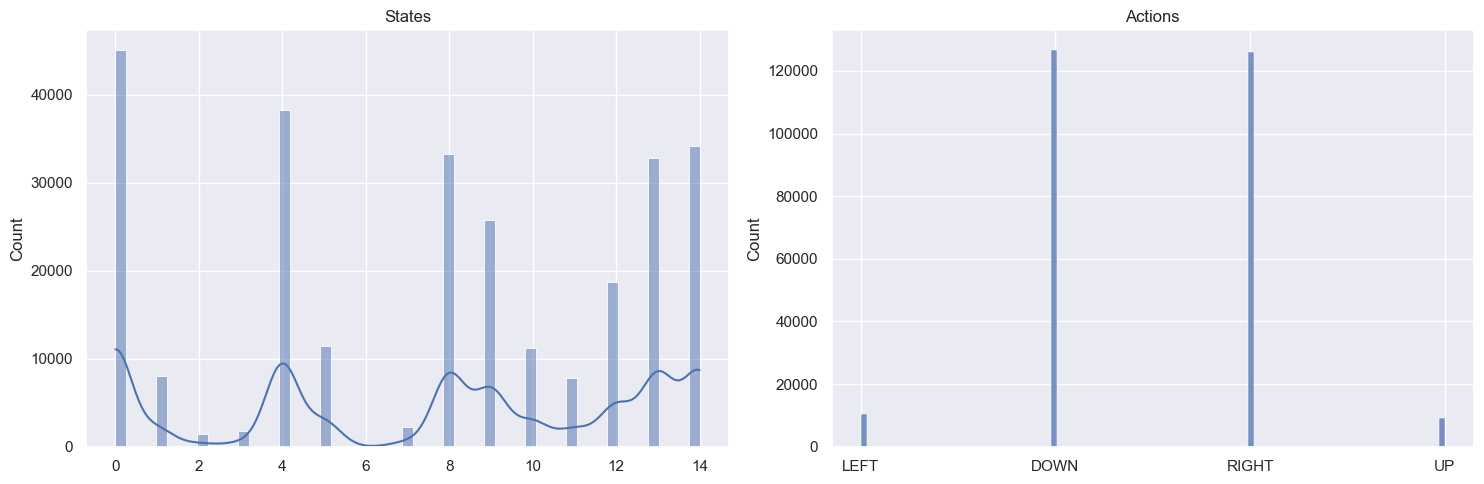

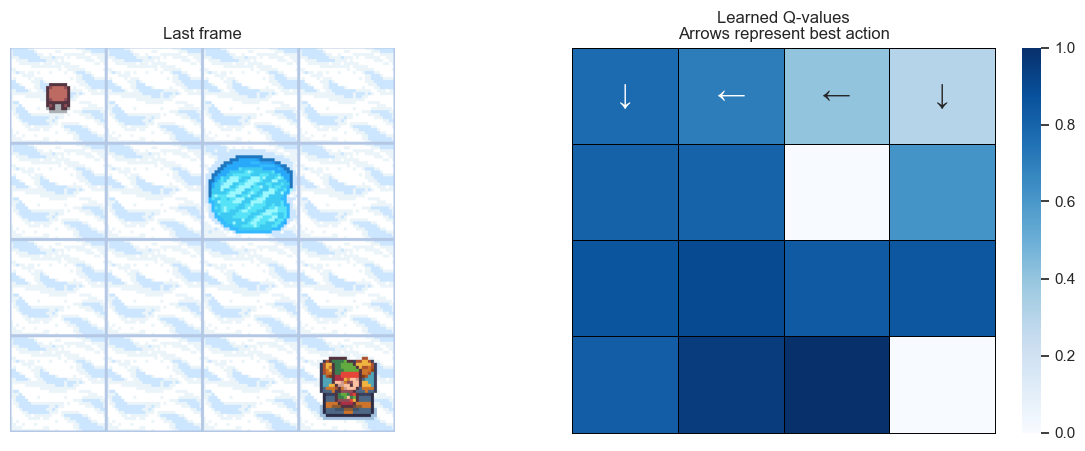

Map size: 7x7


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


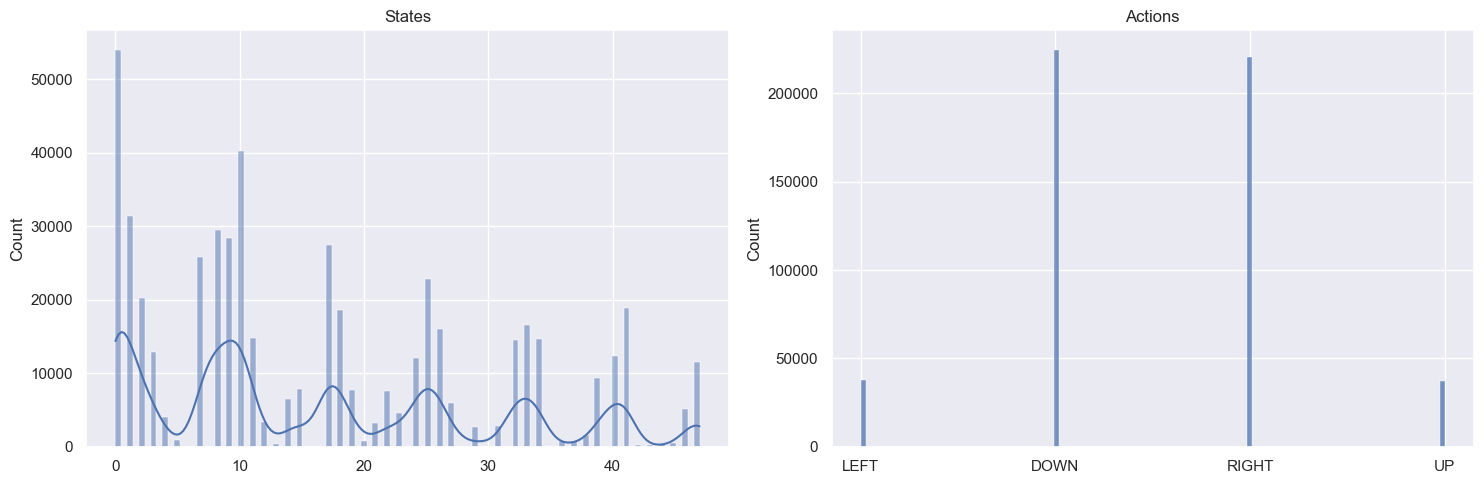

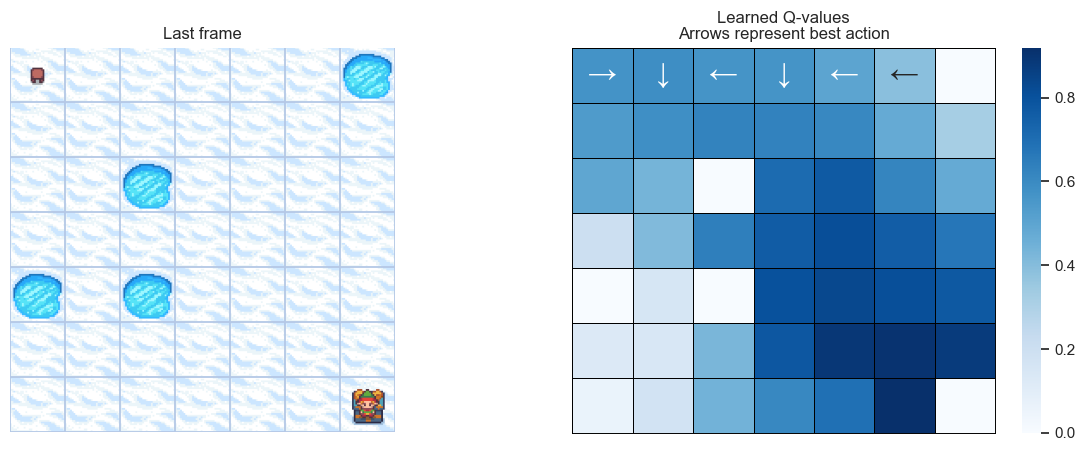

Map size: 9x9


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


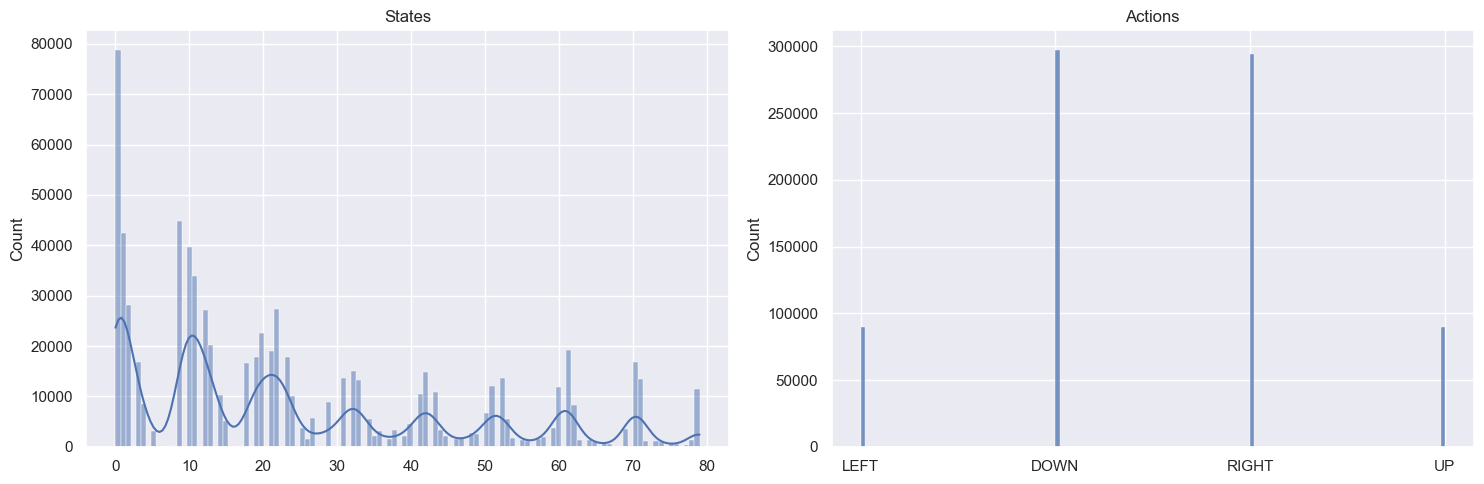

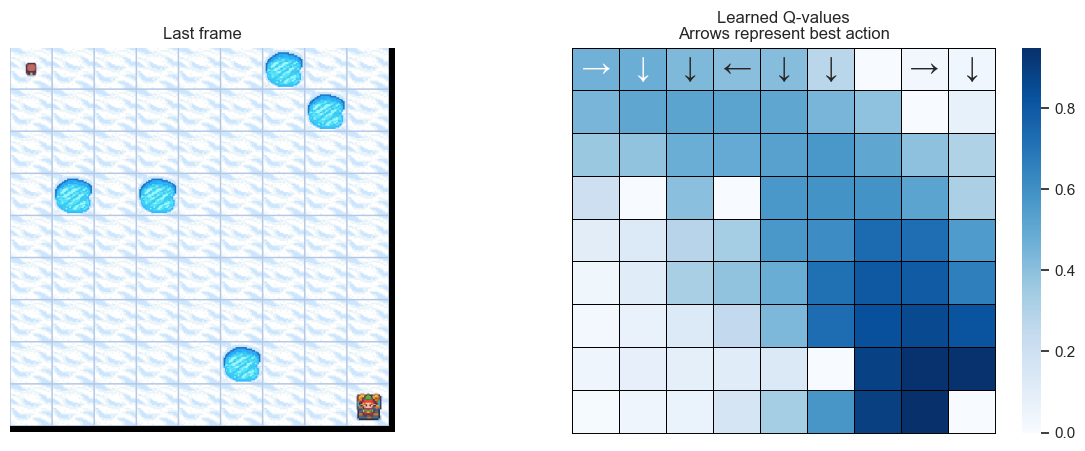

Map size: 11x11


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


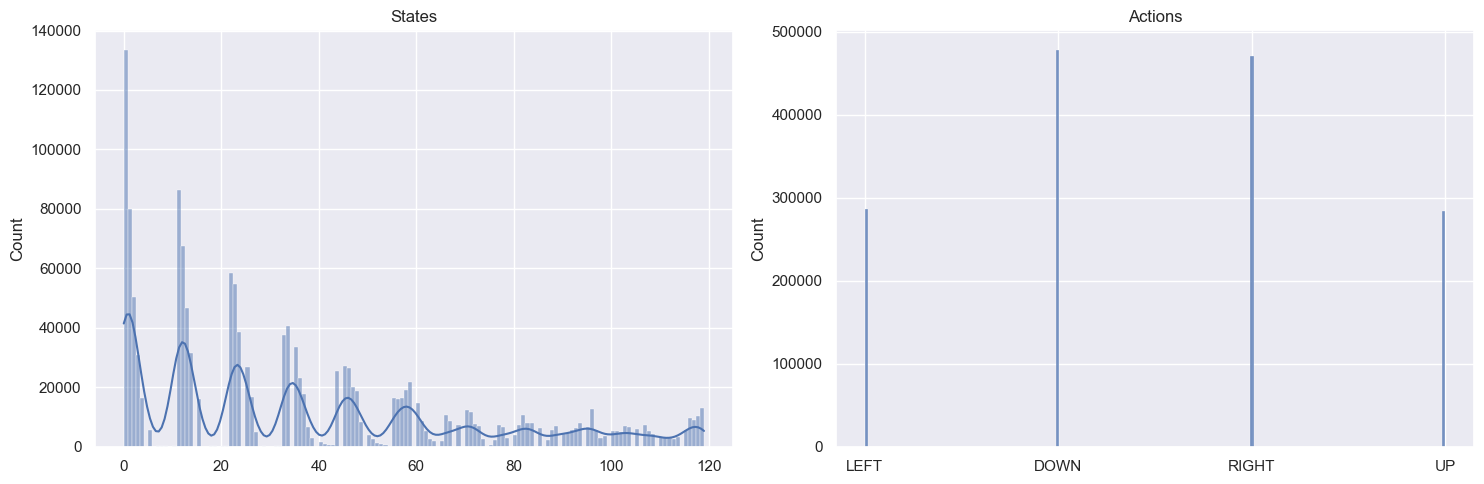

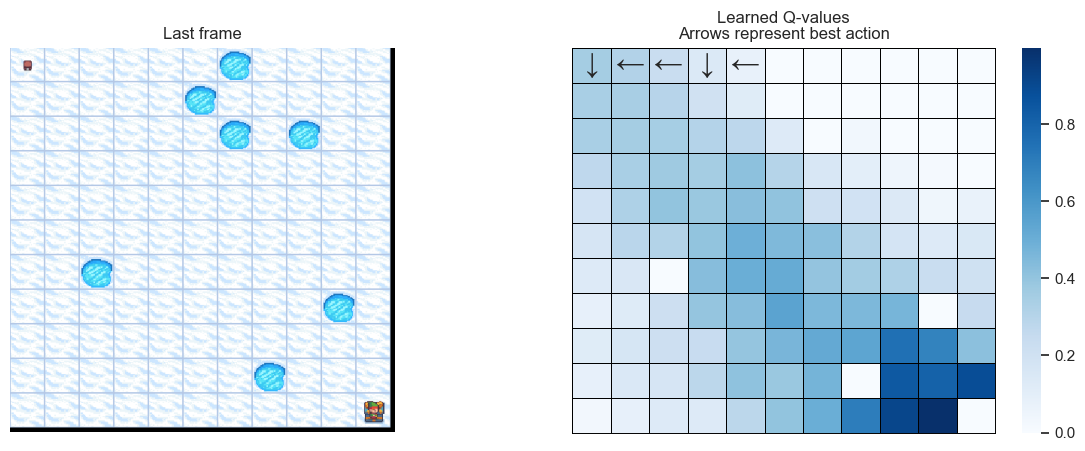

In [15]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

# Params_2

Map size: 4x4


Run 0/30 - Episodes:   0%|                             | 0/3000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


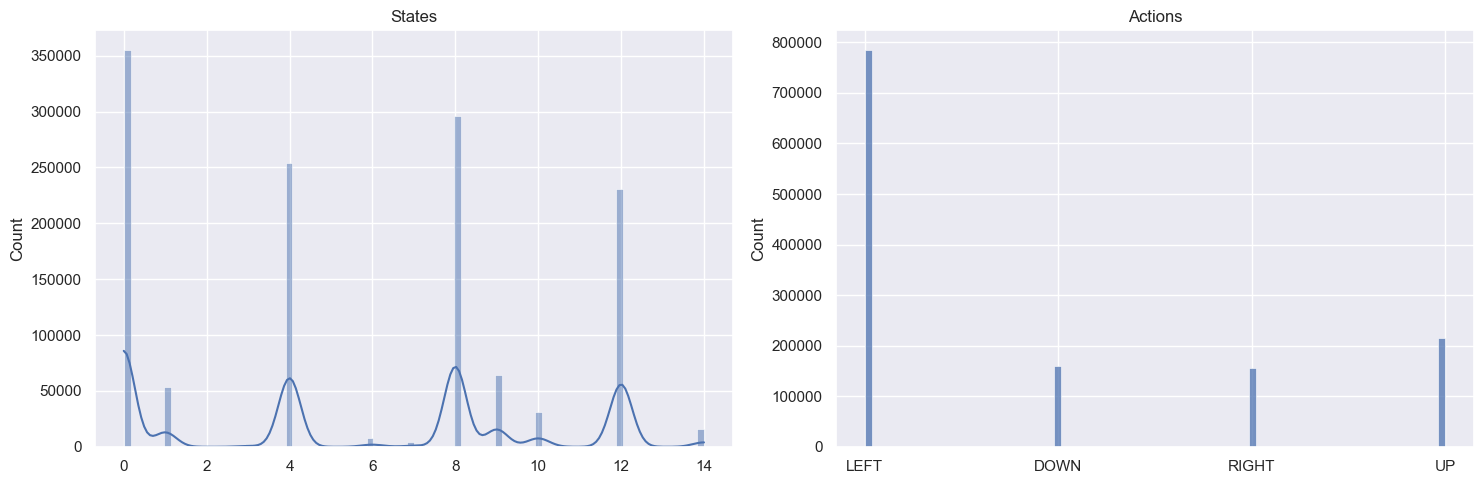

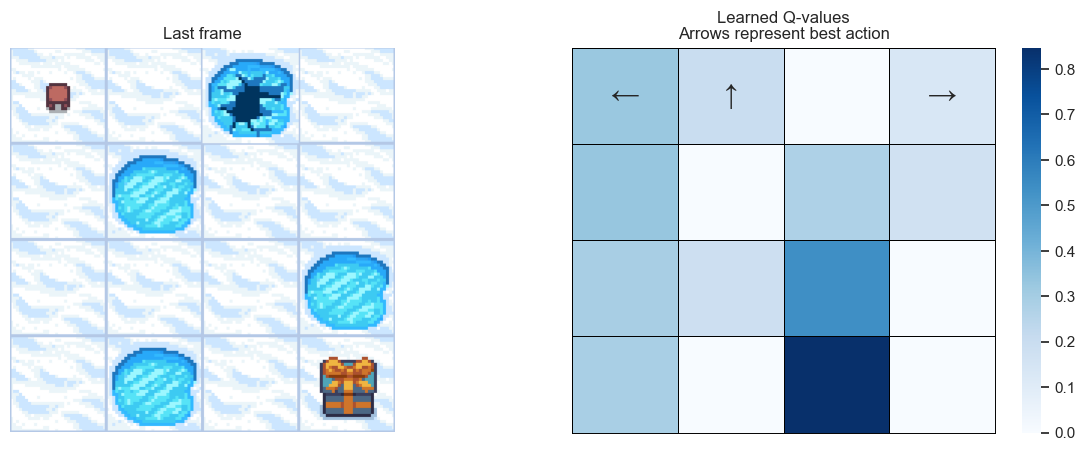

Map size: 7x7


Run 0/30 - Episodes:   0%|                             | 0/3000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


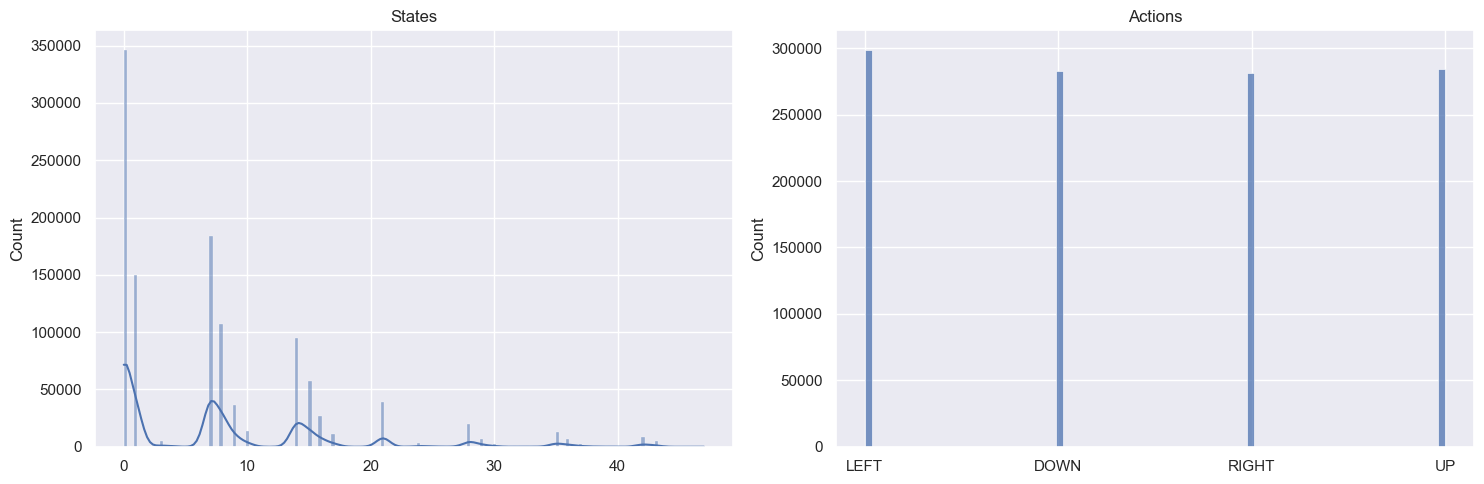

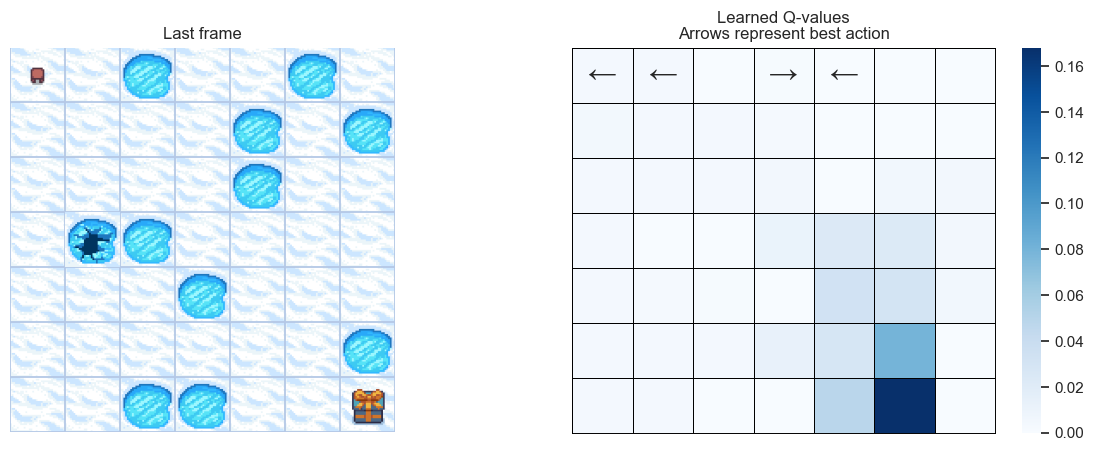

Map size: 9x9


Run 0/30 - Episodes:   0%|                             | 0/3000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


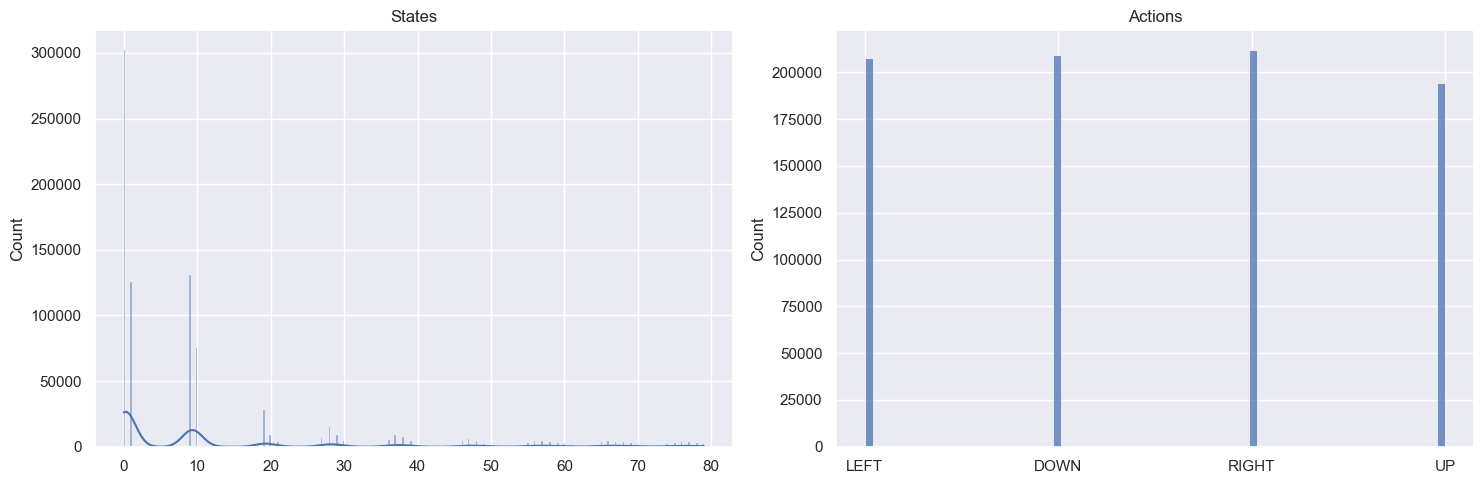

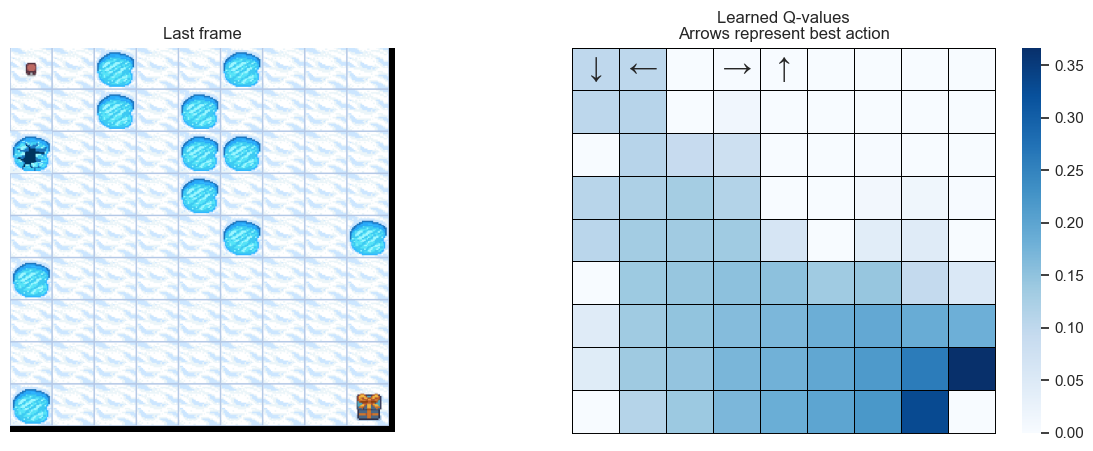

Map size: 11x11


Run 0/30 - Episodes:   0%|                             | 0/3000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


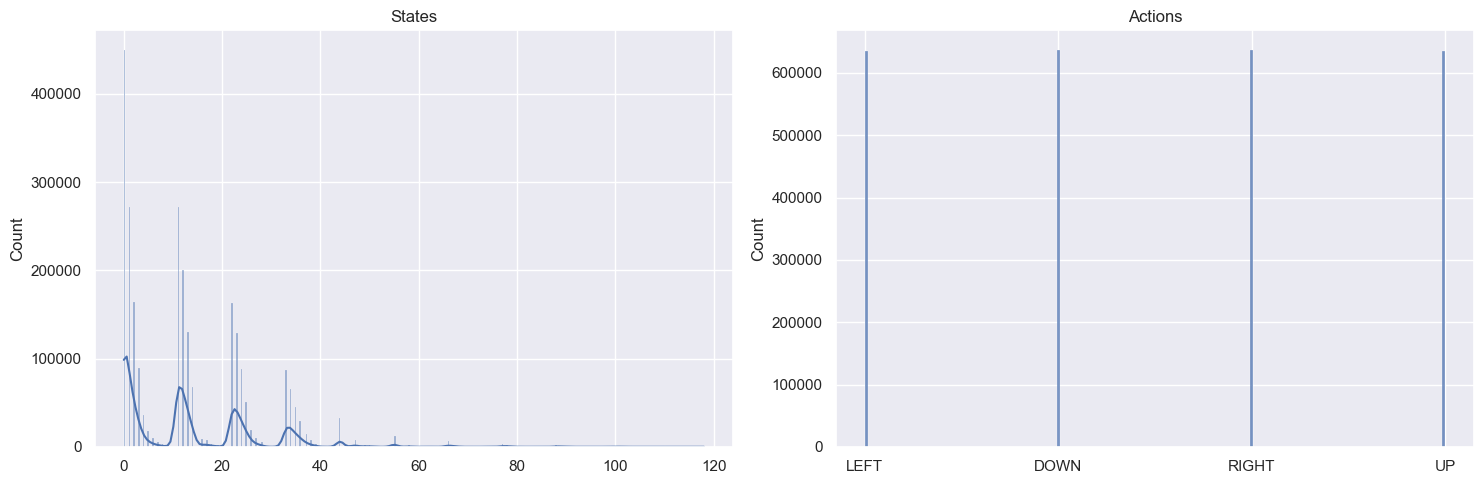

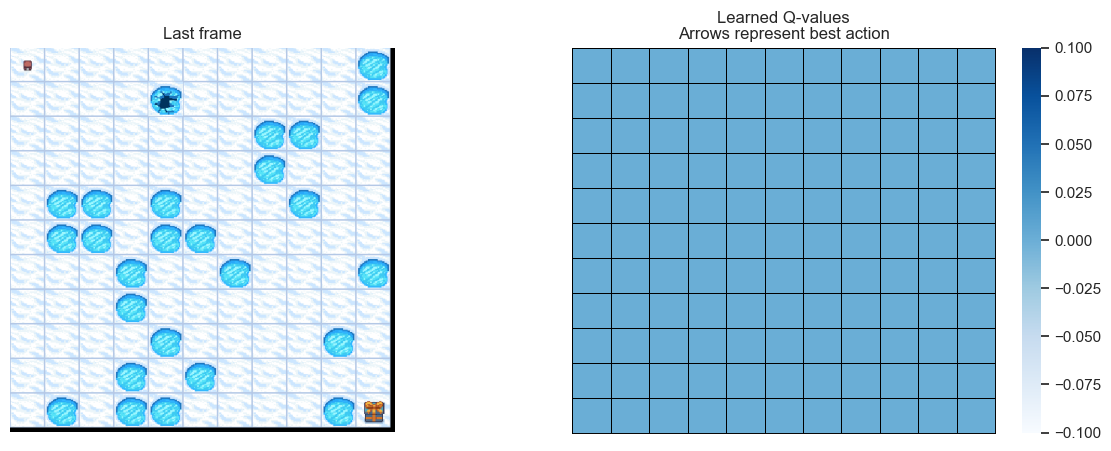

In [32]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()
params=params_2

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

# Params_3

Map size: 4x4


Run 0/25 - Episodes:   0%|                             | 0/1500 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


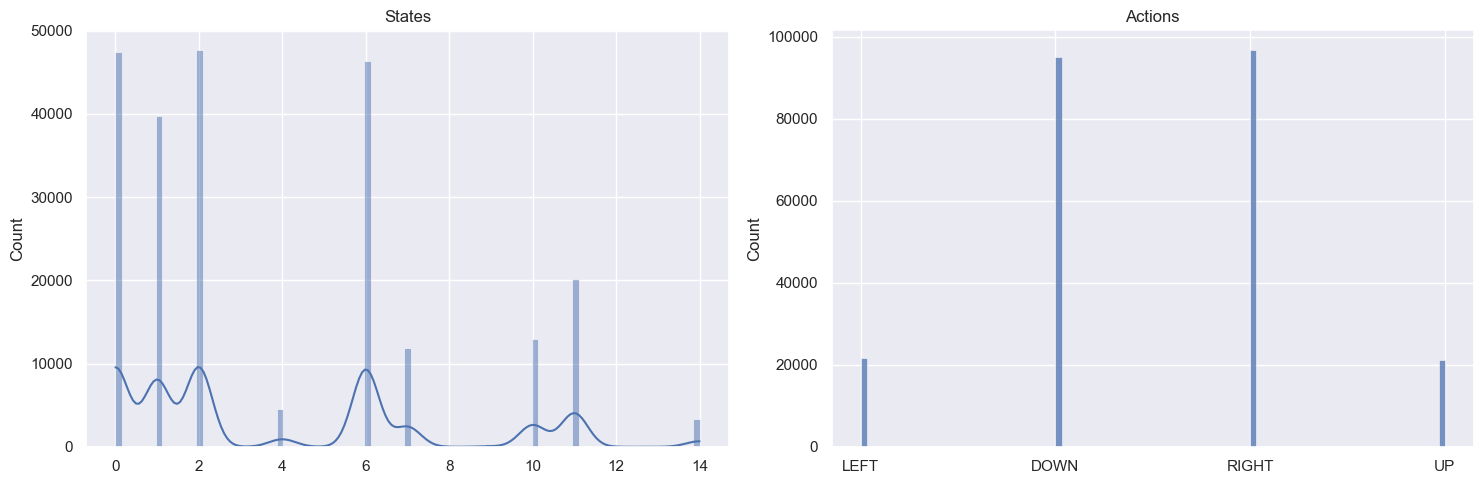

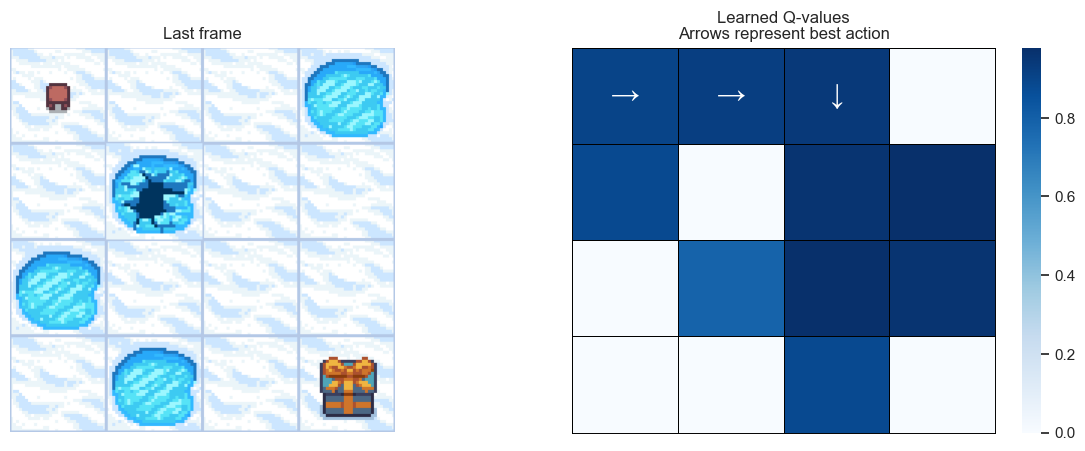

Map size: 7x7


Run 0/25 - Episodes:   0%|                             | 0/1500 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


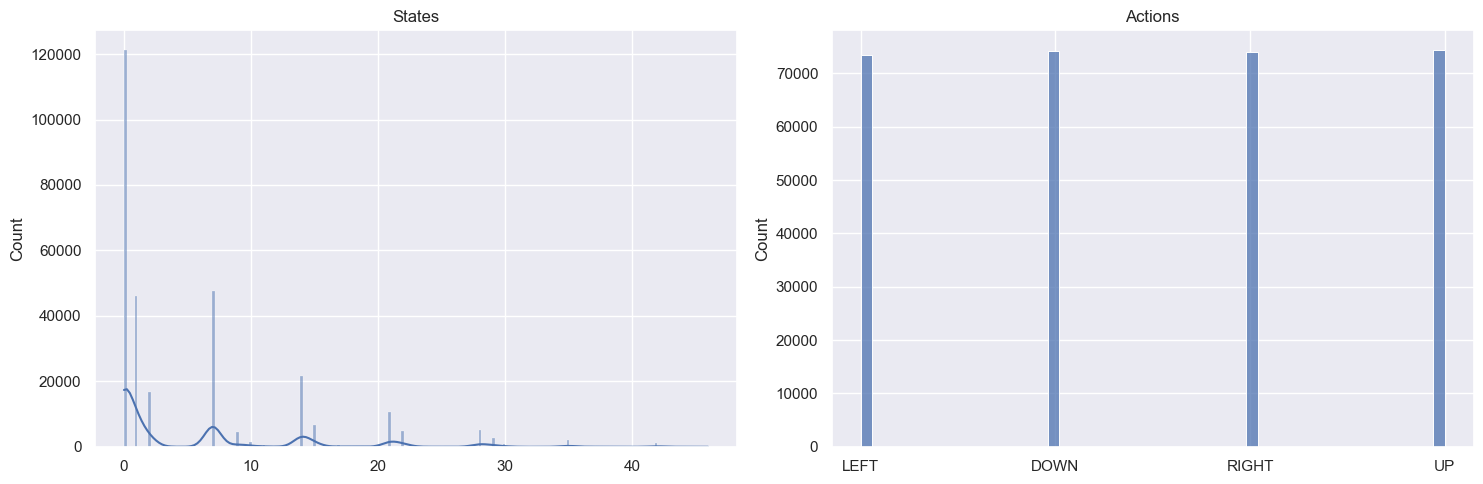

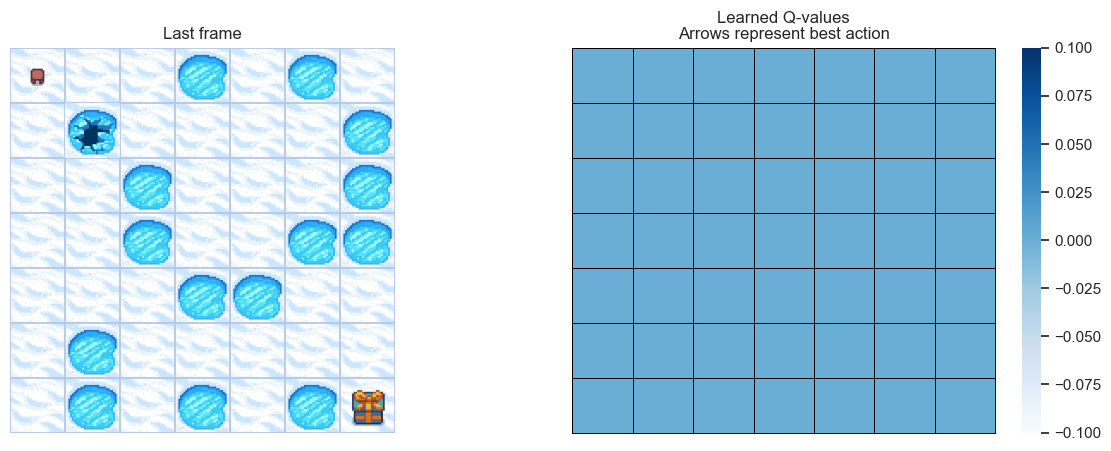

Map size: 9x9


Run 0/25 - Episodes:   0%|                             | 0/1500 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


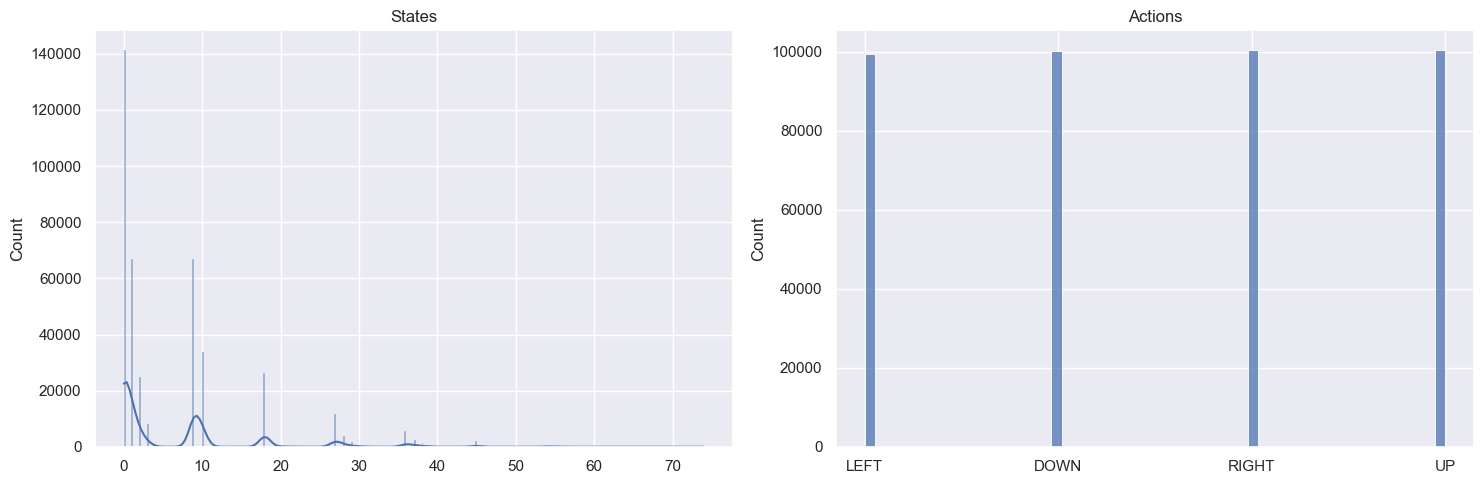

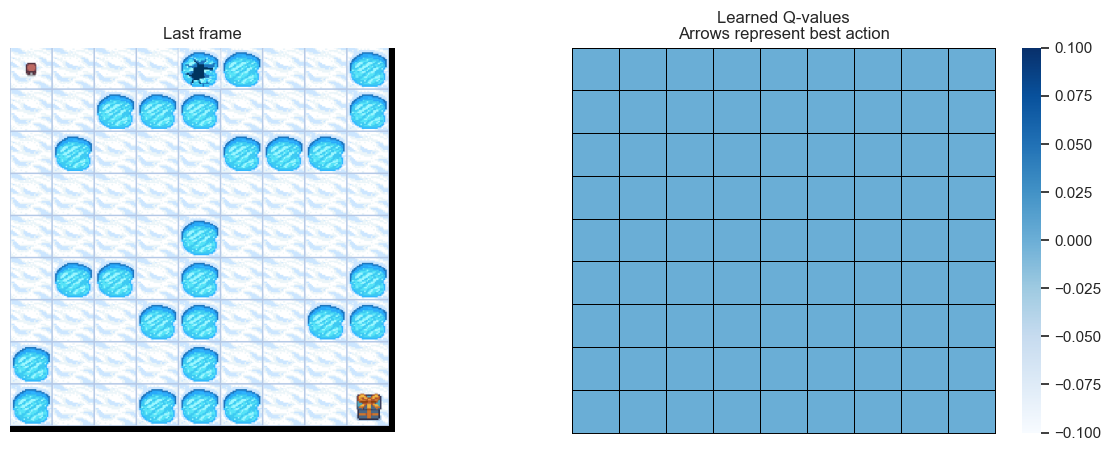

Map size: 11x11


Run 0/25 - Episodes:   0%|                             | 0/1500 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


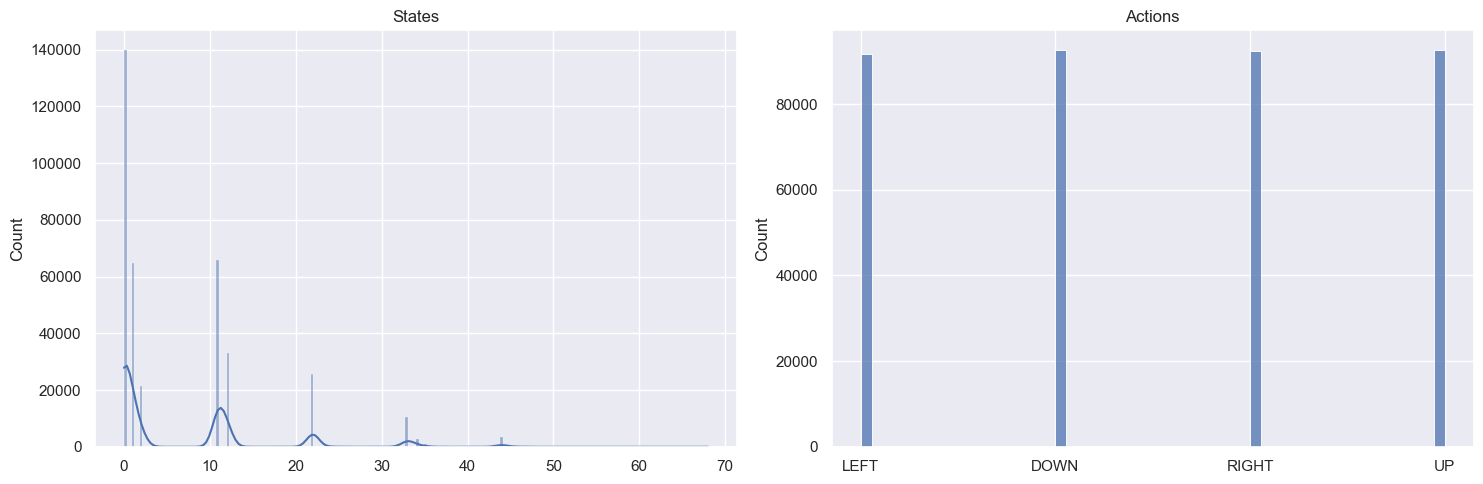

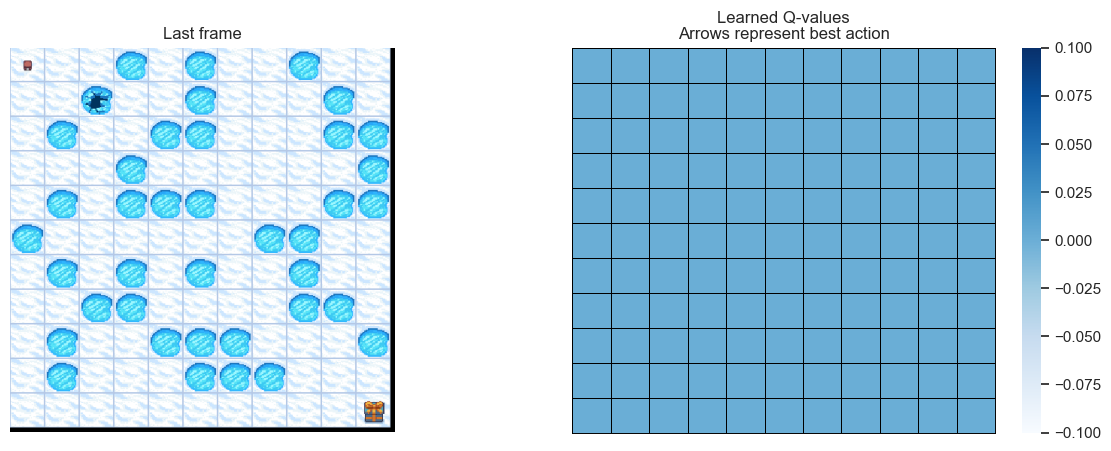

In [33]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()
params=params_3

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

#### Map size: $4 \times 4$




|States actions histogram 4x4 map| |Q-values 4x4 map|

.. |States actions histogram 4x4 map| image:: ../../_static/img/tutorials/frozenlake_states_actions_distrib_4x4.png
.. |Q-values 4x4 map| image:: ../../_static/img/tutorials/frozenlake_q_values_4x4.png





#### Map size: $7 \times 7$




|States actions histogram 7x7 map| |Q-values 7x7 map|

.. |States actions histogram 7x7 map| image:: ../../_static/img/tutorials/frozenlake_states_actions_distrib_7x7.png
.. |Q-values 7x7 map| image:: ../../_static/img/tutorials/frozenlake_q_values_7x7.png





#### Map size: $9 \times 9$




|States actions histogram 9x9 map| |Q-values 9x9 map|

.. |States actions histogram 9x9 map| image:: ../../_static/img/tutorials/frozenlake_states_actions_distrib_9x9.png
.. |Q-values 9x9 map| image:: ../../_static/img/tutorials/frozenlake_q_values_9x9.png





#### Map size: $11 \times 11$




|States actions histogram 11x11 map| |Q-values 11x11 map|

.. |States actions histogram 11x11 map| image:: ../../_static/img/tutorials/frozenlake_states_actions_distrib_11x11.png
.. |Q-values 11x11 map| image:: ../../_static/img/tutorials/frozenlake_q_values_11x11.png





The ``DOWN`` and ``RIGHT`` actions get chosen more often, which makes
sense as the agent starts at the top left of the map and needs to find
its way down to the bottom right. Also the bigger the map, the less
states/tiles further away from the starting state get visited.




To check if our agent is learning, we want to plot the cumulated sum of
rewards, as well as the number of steps needed until the end of the
episode. If our agent is learning, we expect to see the cumulated sum of
rewards to increase and the number of steps to solve the task to
decrease.




/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

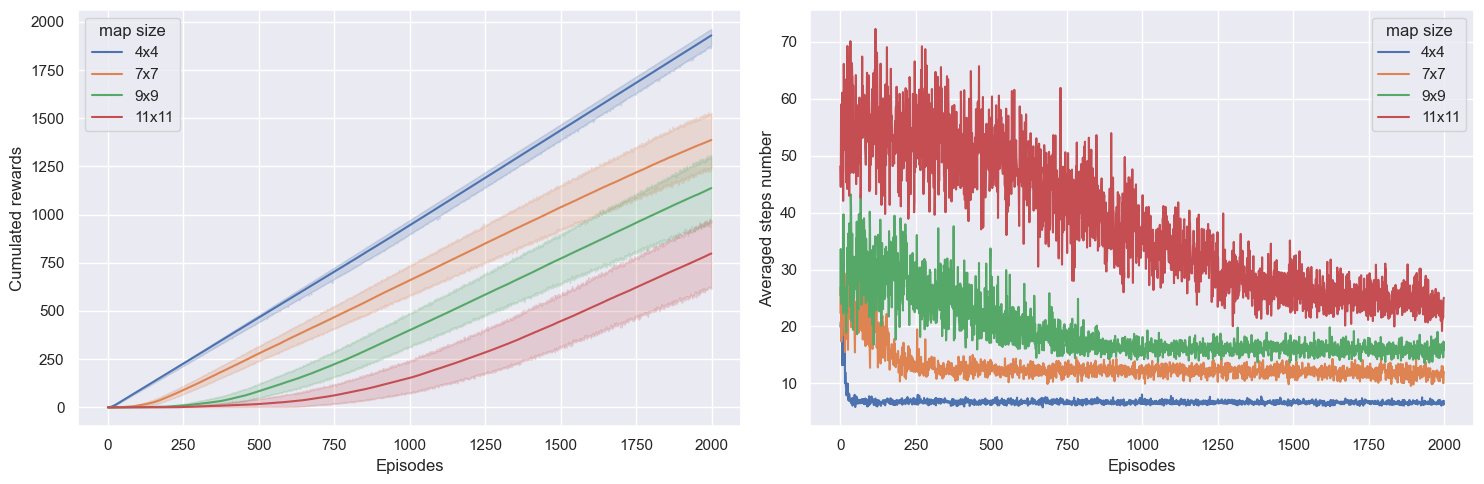

In [16]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

|Steps and rewards|

.. |Steps and rewards| image:: ../../_static/img/tutorials/frozenlake_steps_and_rewards.png





On the $4 \times 4$ map, learning converges pretty quickly,
whereas on the $7 \times 7$ map, the agent needs $\sim 300$
episodes, on the $9 \times 9$ map it needs $\sim 800$
episodes, and the $11 \times 11$ map, it needs $\sim 1800$
episodes to converge. Interestingely, the agent seems to be getting more
rewards on the $9 \times 9$ map than on the $7 \times 7$
map, which could mean it didn't reach an optimal policy on the
$7 \times 7$ map.




# POLICY ITERATION

In [25]:
from gym.envs.toy_text import FrozenLakeEnv

def policy_iteration(env, gamma, threshold=0.001):
    # Initialize the value function
    value_table = np.zeros(env.observation_space.n)

    while True:
        delta = 0
        for state in range(env.observation_space.n):
            v = value_table[state]
            action_values = np.zeros(env.action_space.n)
            for action in range(env.action_space.n):
                # Access transition probabilities, rewards, and next states directly
                for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                    action_values[action] += prob * (reward + gamma * value_table[next_state])
            max_action = np.argmax(action_values)
            new_v = action_values[max_action]
            delta = max(delta, abs(v - new_v))
            value_table[state] = new_v
        if delta < threshold:
            break

    # Extract the optimal policy from the value function
    policy = np.zeros(env.observation_space.n)
    for state in range(env.observation_space.n):
        action_values = np.zeros(env.action_space.n)
        for action in range(env.action_space.n):
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                action_values[action] += prob * (reward + gamma * value_table[next_state])
        policy[state] = np.argmax(action_values)

    return policy, value_table

# Create the environment
env = FrozenLakeEnv()

# Set the discount factor
gamma = 0.9

# Run policy iteration
policy, value_table = policy_iteration(env, gamma)

# Print the optimal policy
print("Optimal Policy:")
for state in range(env.observation_space.n):
    print("State:", state, "Action:", policy[state])

# Print the value function
print("Value Function:")
for state in range(env.observation_space.n):
    print("State:", state, "Value:", value_table[state])


Optimal Policy:
State: 0 Action: 0.0
State: 1 Action: 3.0
State: 2 Action: 0.0
State: 3 Action: 3.0
State: 4 Action: 0.0
State: 5 Action: 0.0
State: 6 Action: 0.0
State: 7 Action: 0.0
State: 8 Action: 3.0
State: 9 Action: 1.0
State: 10 Action: 0.0
State: 11 Action: 0.0
State: 12 Action: 0.0
State: 13 Action: 2.0
State: 14 Action: 1.0
State: 15 Action: 0.0
Value Function:
State: 0 Value: 0.06428820521255309
State: 1 Value: 0.05807365207802949
State: 2 Value: 0.07231298596850956
State: 3 Value: 0.05356057409100988
State: 4 Value: 0.08830335671899874
State: 5 Value: 0.0
State: 6 Value: 0.11127288230728
State: 7 Value: 0.0
State: 8 Value: 0.14298807999391197
State: 9 Value: 0.24613327917763989
State: 10 Value: 0.29877496608995363
State: 11 Value: 0.0
State: 12 Value: 0.0
State: 13 Value: 0.3790509700605088
State: 14 Value: 0.6386017419959636
State: 15 Value: 0.0


# PART - 2

## IMPORTING REQUIRED LIBRARIES  

In [17]:
!pip install gym\[atari\]


In [18]:
!pip install git+https://github.com/openai/gym.git#egg=gym[atari]


zsh:1: no matches found: git+https://github.com/openai/gym.git#egg=gym[atari]


In [19]:
!pip install 'gym[atari]'

In [20]:
!pip install --upgrade gym


In [49]:
!pip install --upgrade 'gym[atari]' 

In [53]:
!pip install --upgrade numpy

# USING 'Pong-v0' ENVIRONMENT 

In [80]:
import gym
import numpy as np
import cv2

# Define parameters
class Params:
    def __init__(self, total_episodes, learning_rate, gamma, epsilon, seed, n_runs):
        self.total_episodes = total_episodes
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.seed = seed
        self.n_runs = n_runs

# Create Gym environment
env = gym.make('Pong-v0')  # Example Atari game environment (change as needed)
action_size = env.action_space.n

# Define parameters
params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    seed=123,
    n_runs=20,
)

# Define Q-learning class
class Qlearning:
    def __init__(self, learning_rate, gamma, action_size):
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.qtable = np.zeros((action_size,))

    def update(self, action, reward, next_max_q):
        """Update Q-value."""
        target = reward + self.gamma * next_max_q
        self.qtable[action] += self.learning_rate * (target - self.qtable[action])

# Initialize Q-learning agent
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    action_size=action_size,
)

# Preprocessing function
# Preprocessing function
# Preprocessing function
def preprocess_state(state):
    # Check if the state is a tuple and extract the first element
    if isinstance(state, tuple):
        state = state[0]

    state = np.array(state)  # Convert state to NumPy array
    state = cv2.cvtColor(state, cv2.COLOR_RGB2BGR)  # Convert to BGR format
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    state = cv2.resize(state, (84, 84))  # Resize to match Atari frame size
    state = state.flatten()
    return state



# Training loop
# Training loop
for episode in range(params.total_episodes):
    state = env.reset()
    state = preprocess_state(state)  # Preprocess the initial state
    done = False
    total_reward = 0
    while not done:
        # Choose action using epsilon-greedy strategy
        if np.random.rand() < params.epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(learner.qtable)

        # Perform action and observe new state and reward
        step_result = env.step(action)
        new_state, reward, done, _ = step_result[:4]  # Unpack the first four values
        new_state = preprocess_state(new_state)  # Preprocess the new state

        # Update Q-table
        next_max_q = np.max(learner.qtable)
        learner.update(action, reward, next_max_q)

        state = new_state
        total_reward += reward

    # Print progress
    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}")



Episode: 0, Total Reward: -21.0
Episode: 100, Total Reward: -21.0
Episode: 200, Total Reward: -21.0
Episode: 300, Total Reward: -20.0
Episode: 400, Total Reward: -21.0
Episode: 500, Total Reward: -21.0
Episode: 600, Total Reward: -20.0
Episode: 700, Total Reward: -21.0
Episode: 800, Total Reward: -21.0
Episode: 900, Total Reward: -21.0
Episode: 1000, Total Reward: -21.0
Episode: 1100, Total Reward: -21.0
Episode: 1200, Total Reward: -21.0
Episode: 1300, Total Reward: -21.0
Episode: 1400, Total Reward: -21.0
Episode: 1500, Total Reward: -21.0
Episode: 1600, Total Reward: -20.0
Episode: 1700, Total Reward: -21.0
Episode: 1800, Total Reward: -21.0
Episode: 1900, Total Reward: -21.0


# USING 'SpaceInvaders-v0' ENVIRONMENT 

/opt/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/opt/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0, Total Reward: 120.0
Episode: 100, Total Reward: 40.0
Episode: 200, Total Reward: 120.0
Episode: 300, Total Reward: 225.0
Episode: 400, Total Reward: 215.0
Episode: 500, Total Reward: 180.0
Episode: 600, Total Reward: 75.0
Episode: 700, Total Reward: 365.0
Episode: 800, Total Reward: 65.0
Episode: 900, Total Reward: 175.0
Episode: 1000, Total Reward: 495.0
Episode: 1100, Total Reward: 110.0
Episode: 1200, Total Reward: 140.0
Episode: 1300, Total Reward: 120.0
Episode: 1400, Total Reward: 55.0
Episode: 1500, Total Reward: 405.0
Episode: 1600, Total Reward: 55.0
Episode: 1700, Total Reward: 250.0
Episode: 1800, Total Reward: 430.0
Episode: 1900, Total Reward: 65.0


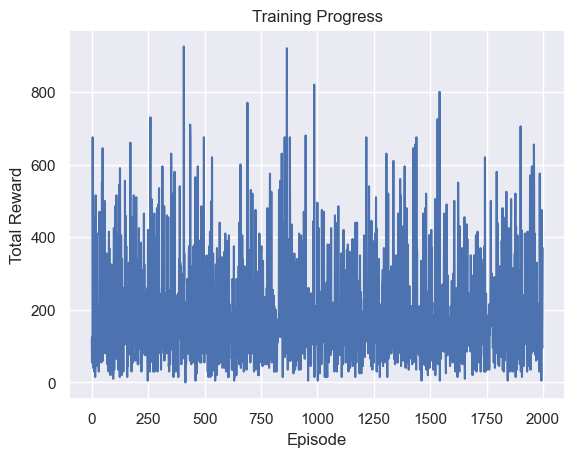

In [26]:
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define parameters
class Params:
    def __init__(self, total_episodes, initial_learning_rate, gamma, epsilon, seed, n_runs):
        self.total_episodes = total_episodes
        self.initial_learning_rate = initial_learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.seed = seed
        self.n_runs = n_runs

# Create Gym environment
env = gym.make('SpaceInvaders-v0')  # Example Atari game environment (change as needed)
action_size = env.action_space.n

# Define parameters
params = Params(
    total_episodes=2000,
    initial_learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    seed=123,
    n_runs=20,
)

# Define Q-learning class
class Qlearning:
    def __init__(self, initial_learning_rate, gamma, epsilon, action_size):
        self.initial_learning_rate = initial_learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.qtable = np.zeros((action_size,))
        self.learning_rate = initial_learning_rate  # Set initial learning rate

    def update(self, action, reward, next_max_q):
        """Update Q-value."""
        target = reward + self.gamma * next_max_q
        self.qtable[action] += self.learning_rate * (target - self.qtable[action])

    def update_learning_rate(self, episode):
        """Update learning rate."""
        # Example: exponential decay
        self.learning_rate = self.initial_learning_rate * np.exp(-0.0005 * episode)

# Initialize Q-learning agent
learner = Qlearning(
    initial_learning_rate=params.initial_learning_rate,
    gamma=params.gamma,
    epsilon=params.epsilon,  # Include epsilon as an attribute
    action_size=action_size,
)

# Preprocessing function
def preprocess_state(state):
    if isinstance(state, tuple):
        state = state[0]
    state = np.array(state)
    state = cv2.cvtColor(state, cv2.COLOR_RGB2BGR)
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
    state = cv2.resize(state, (84, 84))
    state = state.flatten()
    return state

# Training loop
episode_rewards = []  # Store episode rewards for plotting
for episode in range(params.total_episodes):
    state = env.reset()
    state = preprocess_state(state)  # Preprocess the initial state
    done = False
    total_reward = 0
    while not done:
        # Choose action using epsilon-greedy strategy
        if np.random.rand() < learner.epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(learner.qtable)

        # Perform action and observe new state and reward
        step_result = env.step(action)
        new_state, reward, done, _ = step_result[:4]  # Unpack the first four values
        new_state = preprocess_state(new_state)  # Preprocess the new state

        # Update Q-table
        next_max_q = np.max(learner.qtable)
        learner.update(action, reward, next_max_q)
        
        # Update learning rate
        learner.update_learning_rate(episode)

        state = new_state
        total_reward += reward

    # Append total reward of current episode
    episode_rewards.append(total_reward)
    
    # Print progress
    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}")

# Plotting the training progress
plt.plot(range(params.total_episodes), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.grid(True)
plt.show()


# REPORT

### Training Progress:
The episode rewards fluctuate throughout the training process, indicating variability in the agent's performance across episodes.
The initial rewards are relatively high (e.g., Episode 0: 120.0), suggesting the agent might be making random but favorable moves early in training.
There are instances of both high and low rewards throughout training, indicating the agent's learning process is not consistently improving.
### Performance Analysis:
The agent achieves a wide range of total rewards, from as low as 40.0 to as high as 495.0.
Notably, there are spikes in rewards at certain episodes (e.g., Episode 1000: 495.0), indicating potential breakthroughs or periods of significant learning.
However, there are also episodes with relatively low rewards (e.g., Episode 600: 75.0), suggesting instances where the agent struggled to perform well.
### Learning Dynamics:
The fluctuating rewards suggest that the agent's learning dynamics are complex and influenced by various factors, including exploration-exploitation trade-offs, environmental stochasticity, and the effectiveness of the learning algorithm.
The non-monotonic behavior of episode rewards suggests that the agent encounters challenges or learns new strategies that impact its performance unpredictably.
### Further Analysis:
To gain deeper insights into the agent's learning progress, additional analysis is required, such as examining learning curves, exploring the effect of different hyperparameters, and evaluating the agent's behavior in specific game scenarios.
It would also be beneficial to investigate whether the observed fluctuations in rewards converge to a stable performance level over more extensive training runs or if they persist indefinitely.
### Improvements and Future Work:
To improve the agent's performance, potential areas for exploration include adjusting hyperparameters (e.g., learning rate, epsilon decay rate), incorporating more advanced techniques (e.g., prioritized experience replay, dueling Q-networks), and experimenting with different network architectures.
Conducting multiple training runs with varying seeds and averaging results could provide a more robust assessment of the agent's capabilities and highlight the stability of its learned policies.